# Stepwise Variable Selection

Stepwise variable selection focuses on reducing the number of input variables to those that are believed to be most useful to a model in order to predict the target variable by removing non-informative or redundant predictors from the model.

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

Today we are going to use the [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), which consists of price of houses in various regions in California. Alongside with price, the dataset also provide information such as average number of bedrooms, population of the area, and latitude/longitude, among others.

## Table of Contents
[1. Loading data & checking high-level details](#Step-1:-Loading-data-&-checking-high-level-details) <br>
- [Data Dictionary](#Data-Dictionary)



[2. Verifying assumptions associated with linear regression models](#Step-2:-Verifying-assumptions-associated-with-linear-regression-models) <br>
- [Linearity](#2.1.-Linearity) <br>
- [Independence](#2.2.-Independence-or-No-Multicollienearity)
- [Normality](#2.3.-Residuals-Are-Normally-Distributed)
- [Homoscedasticity](#2.4.-Homoscedasticity)

[3. Variable selection for model](#Step-3:-Variable-selection-for-model) <br>
- [Backward or Top-Down approach](#3.1.-Backward-or-Top-Down-approach)
- [Forward or Bottom-Up approach](#3.2.-Forward-or-Bottom-Up-approach)

[4. Model Diagnostics](#Step-4:-Model-Diagnostics)
- [Residuals](#4.1.-Residuals)
- [Homoscedasticity](#4.2-Homoscedasticity)

[5. Conclusion](#5.-Conclusion)

In [50]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

## Step 1: Loading data & checking high-level details

In [51]:
# loading the data

cal_df = pd.read_csv('data/california_housing.csv') 

In [52]:
# View the dataframe head

cal_df.head()

,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [53]:
# Take a look at the tail
cal_df.tail()

,Unnamed: 0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20635,20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [54]:
cal_df.drop(columns='Unnamed: 0', inplace=True) # dropping the unneeded column (prior index)

In [55]:
cal_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Data Dictionary

**Variables:**   

- `MedInc:` median income in block group
- `HouseAge:` median house age in block group
- `AveRooms:` average number of rooms per household
- `AveBedrms:` average number of bedrooms per household
- `Population:` block group population
- `AveOccup:` average number of household members
- `Latitude:` block group latitude
- `Longitude:` block group longitude  

**Target:**  
- `MedHouseVal`: median house value for California districts, expressed in hundreds of thousands of dollars ($100,000) 

Let's visualize some of the data to get an idea of what we are working with.  

In [56]:
# Quickly check the data types
cal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [57]:
# Take a look at the shape of dataset
print(f'There are {cal_df.shape[0]} rows and {cal_df.shape[1]} columns in the dataset.')

There are 20640 rows and 9 columns in the dataset.


In [58]:
# Checking for nulls
cal_df.isnull().sum().any()

False

In [59]:
# Checking for duplicates
# Columns 
print(f'Duplicated columns: {cal_df.T.duplicated().any()}')
# Rows 
print(f'Duplicated rows: {cal_df.duplicated().any()}')

Duplicated columns: False
Duplicated rows: False


In [60]:
# Summary statistics 
cal_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


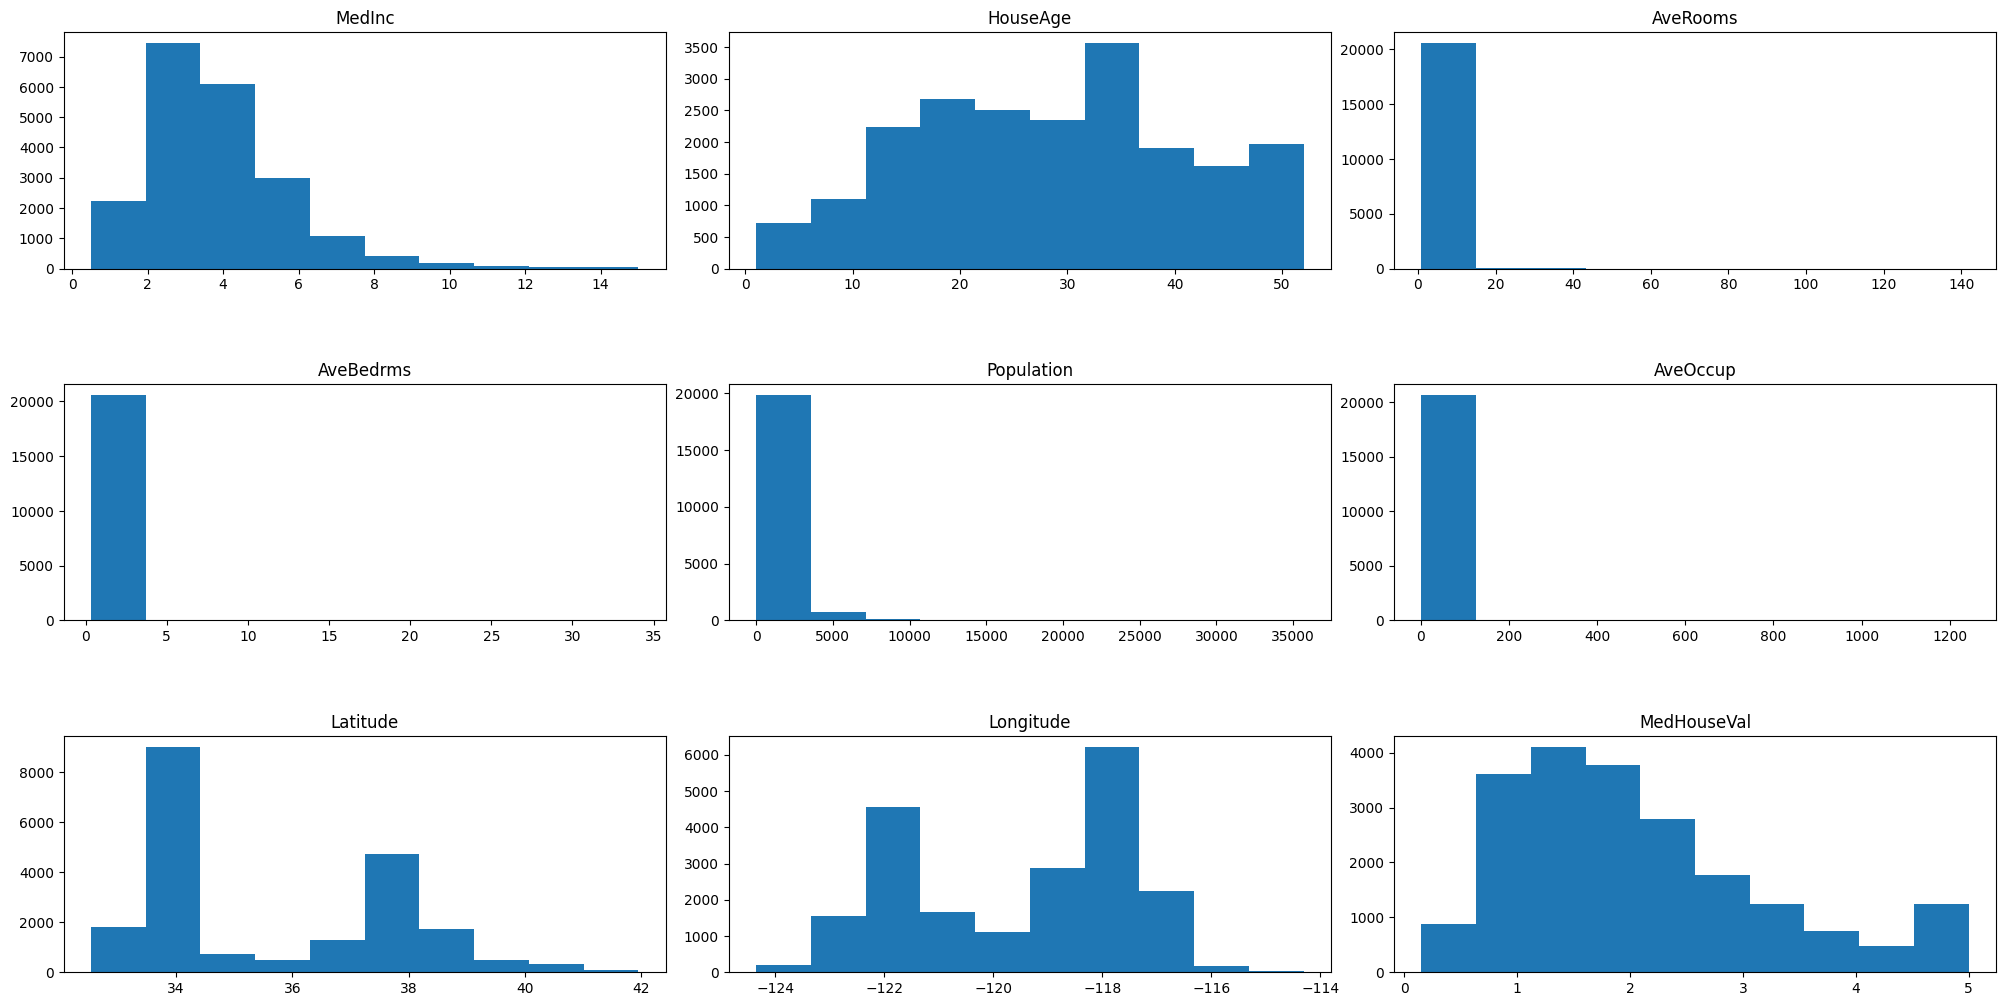

In [61]:
# Lets check out the distributions.

# Setting the plots layout
plt.subplots(3, 3, figsize=(20, 10))

# Plotting
for i, column in enumerate(cal_df.columns, 1):
    plt.subplot(3, 3, i)
    plt.hist(cal_df[column])
    plt.title(column)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

We do see two peaks on the lat and long showing some clustering with respect to location - let's see what this looks like on a scatter plot:

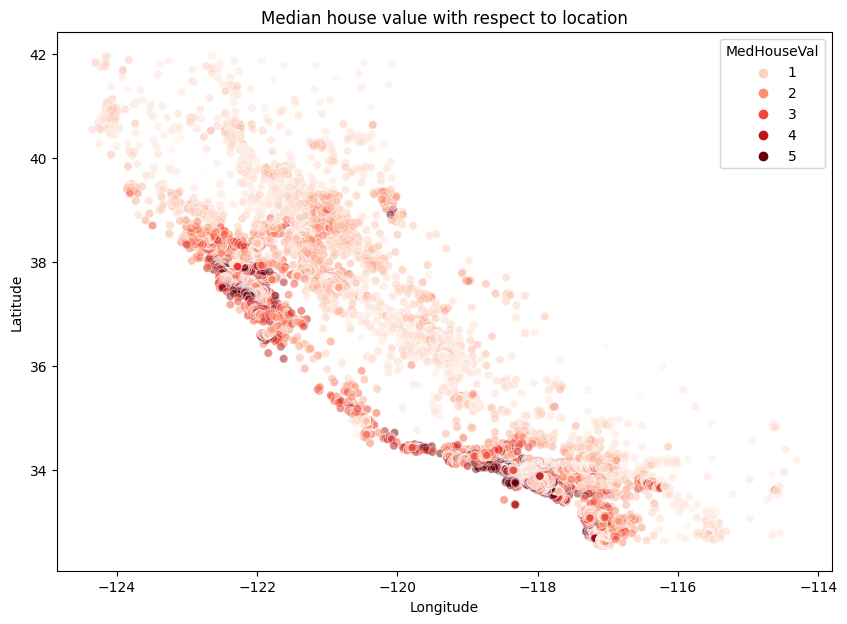

In [62]:
plt.figure(figsize=(10, 7))

sns.scatterplot(data=cal_df, x="Longitude", y="Latitude", hue="MedHouseVal", palette="Reds", alpha=0.5)
plt.title("Median house value with respect to location")
plt.show()

This visualization shows that more expensive housing occurs along the coastlines of California. Location therefore will probably be an important predictor for median house value! 

## Step 2: Verifying assumptions associated with linear regression models

There are four assumptions associated with a linear regression model:

1. **Linearity**: The relationship between the predictor and target variables to be linear.
2. **Independence/No Multicollinearity**: The predictor variables are independent of each other.
3. **Residuals** are normally distributed.**
4. **Homoscedasticity**: The variance of residual is the same for any value of X.**

`** Will be tested after modelling.`

In [63]:
# Separate the data into X and y variables
# X is the data containing the independent variables.
# y is the target.  The dependent variable.
X = cal_df.drop(columns='MedHouseVal')
y = cal_df['MedHouseVal']

In [64]:
# Checking the shape of X and y variables

print(f'Original data set had {cal_df.shape[0]} rows and {cal_df.shape[1]} columns.')
print(f'X has {X.shape[0]} rows and {X.shape[1]} columns.')
print(f'y has {y.shape[0]} rows and 1 column.')

Original data set had 20640 rows and 9 columns.
X has 20640 rows and 8 columns.
y has 20640 rows and 1 column.


### 2.1. Linearity
One of the assumptions when building a linear regression model is that there is a linear relationship between the predictor variables and the target variable. Let's plot the relationship between X and y.

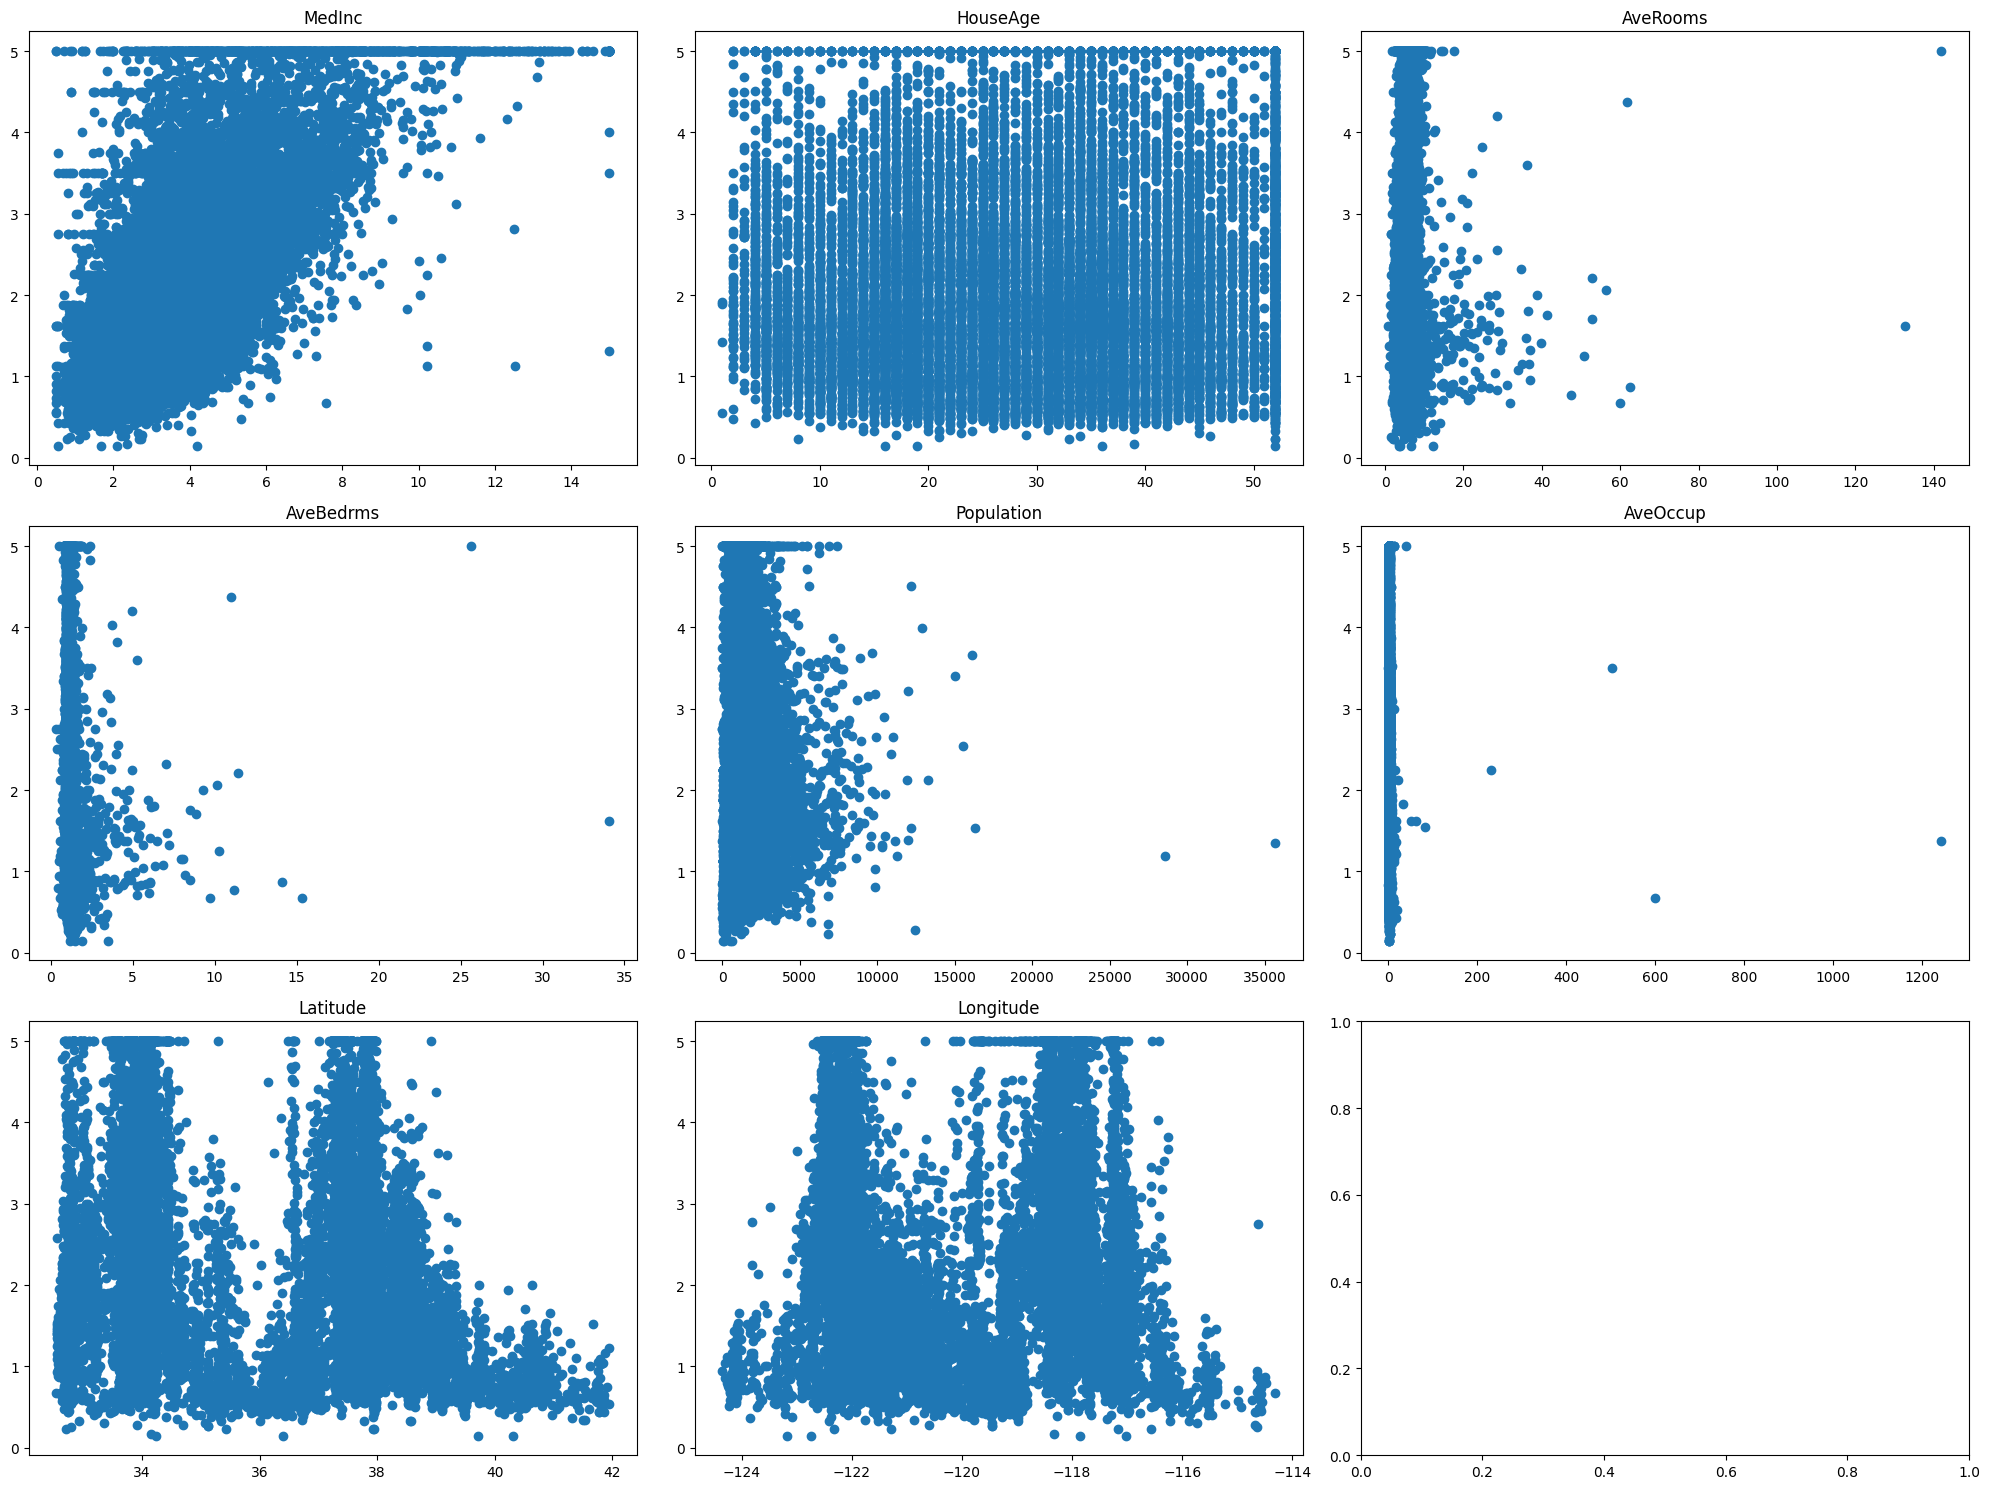

In [65]:
# Loop over the columns and plot the relationship between each column and the target
plt.subplots(3, 3, figsize=(20, 15))

count = 1

for col in X.columns:
    plt.subplot(3, 3, count)
    plt.scatter(X[col], y)
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

As we can see above, there is a distinct linear relationship with the target only one column: `MedInc`. We do see that high lat/lon values also correspond to lower median house value but it is definitely not a clear linear relationship. The other columns are less likely to be useful in a linear model in their current format.

To evaluate this further, we can look at the correlation between `MedHouseVal` and the predictor columns:

In [66]:
cal_df.corr()["MedHouseVal"].sort_values(ascending=False)

MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

We see that `MedInc` shows the highest positive correlation at 0.69 while there is some weak positive correlation with `AveRooms` and weak negative correlation with `Latitude`.

### 2.2. Independence or No Multicollienearity

Another important assumption when building a linear regression is that there is no collinearity: the predictor variables are independent of each other.

We can use `corr()` to display a correlation matrix of the dataset:

In [67]:
# Correlation between independent variables
X_corr = X.corr().style.background_gradient()
X_corr

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000


A correlation matrix is a table showing correlation coefficients between sets of variables. Each variable in the table is correlated with each of the other values in the table. This allows you to see which pairs have the highest correlation. Correlation falls on a range of [-1,1], 
- -1 indicates a perfect negative correlation,
- 0 indicates no correlation,
- and 1 indicates a perfect positive correlation.

Large tables like this are hard to parse through, let's visualize the correlation using a heatmap:

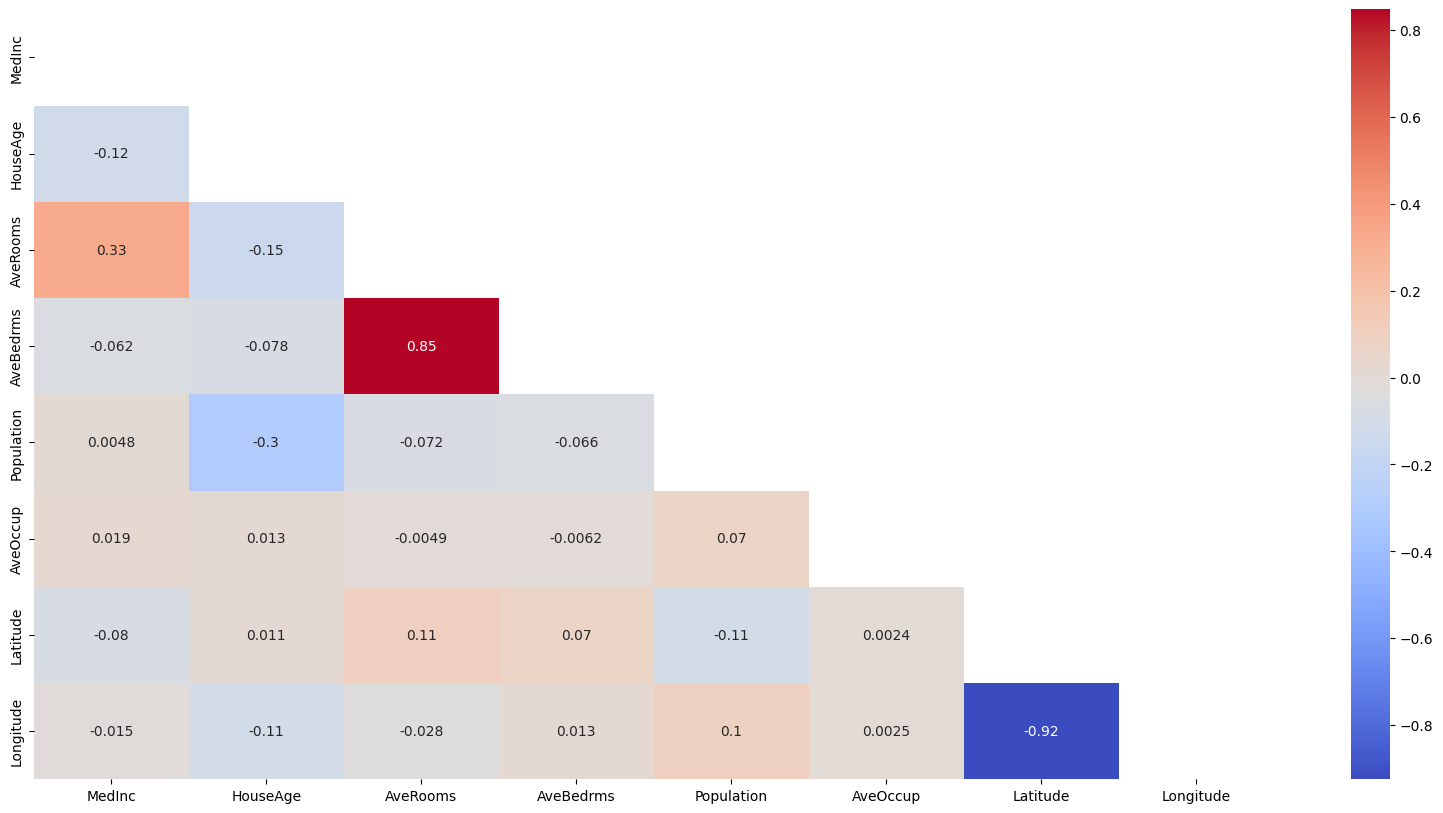

In [68]:
# Correlation of the variables in a heatmap
plt.figure(figsize=(20, 10))
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot=True, mask=matrix, cmap='coolwarm')
plt.show()

Values above 0.5 are usually a concern. As we can see above, there is some strong collinearity in this dataset: for example, `AveBedrooms` is highly correlated with `AveRooms`, and unsuprisingly `Latitude` is positively correlated with `Longtitude` column. We need to make sure to keep this in mind when building our model.

Another way of examining colinearity between variables is by using `pairplot` in Seaborn. This can take a while to run, and can be too difficult to interpret if you have a lot of features:

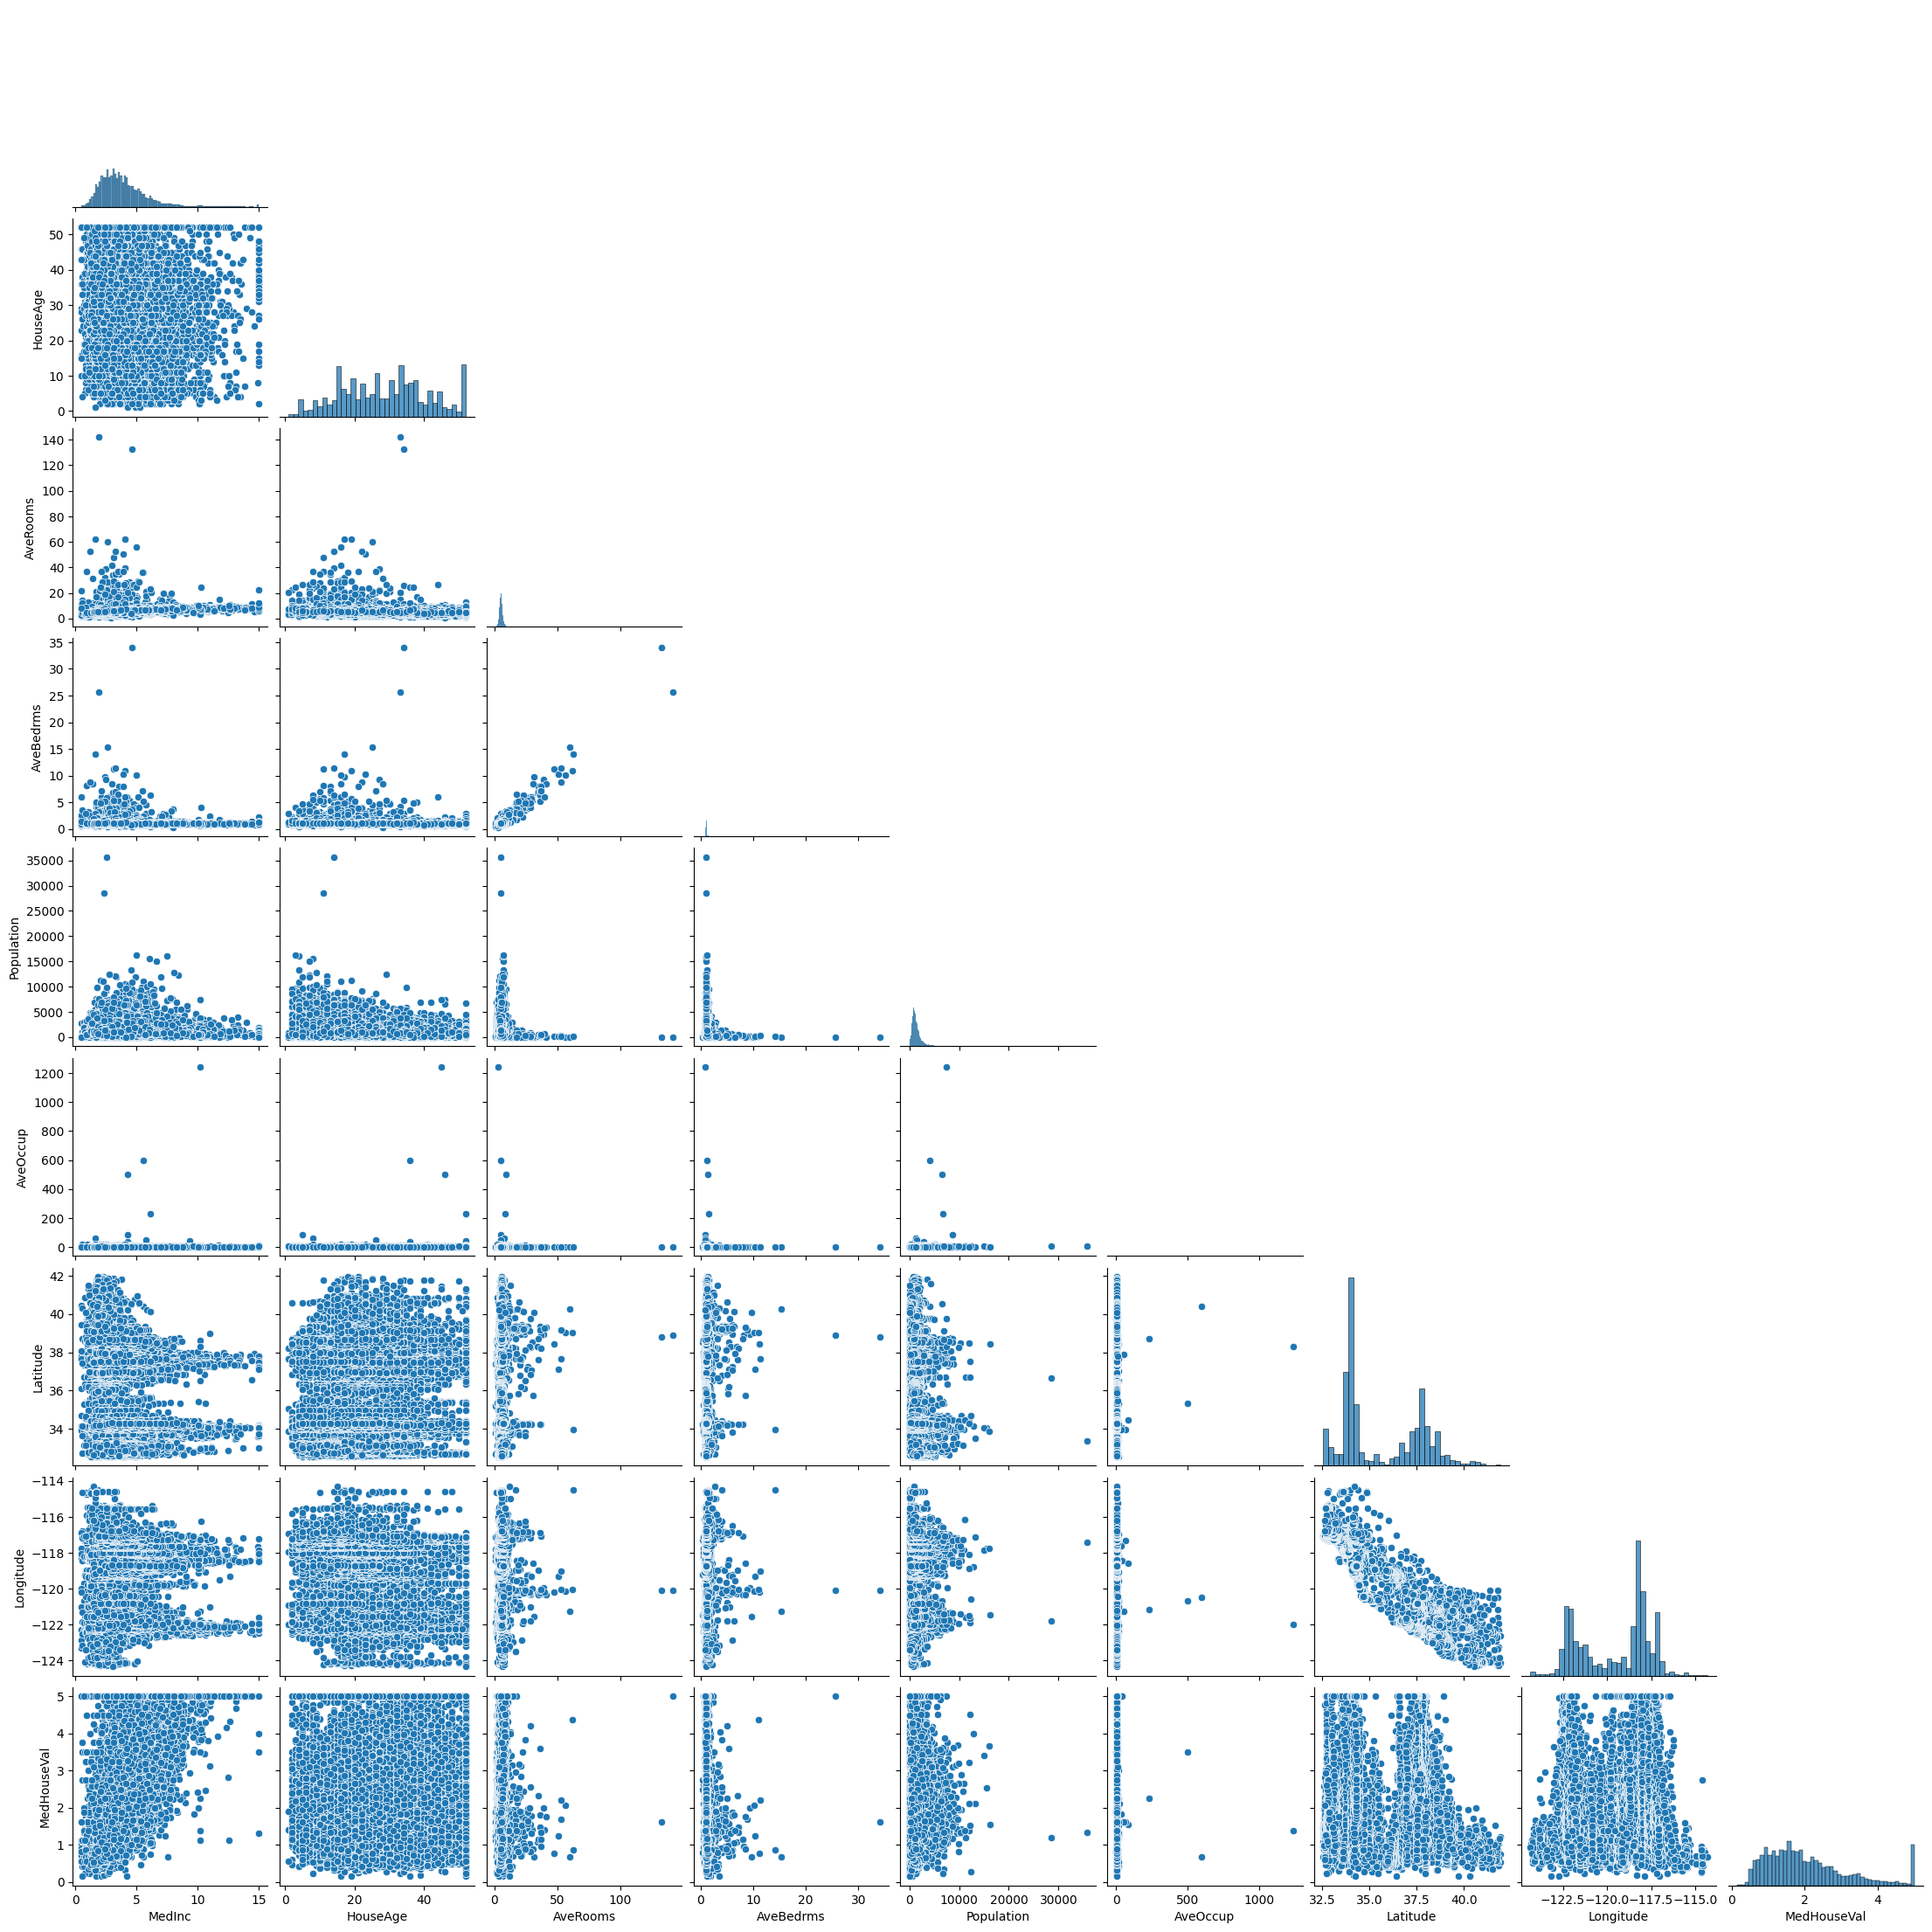

In [69]:
# Use seaborn pairplot to look for collinearity in X variables

sns.pairplot(cal_df, corner=True)
plt.show()

### Supplementary: Variance Inflation Factor

Let's look at **Variance Inflation Factor** (VIF) to detect multicollinearity

When there is no multicollinearity, the VIF for each predictor should be 1. Usually, any VIF value higher than 5 indicates high collinearity. 

In [70]:
# Calculate VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF assumes the presence of a constant in X

X = sm.add_constant(X)

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)[1:]

MedInc        2.501295
HouseAge      1.241254
AveRooms      8.342786
AveBedrms     6.994995
Population    1.138125
AveOccup      1.008324
Latitude      9.297624
Longitude     8.962263
dtype: float64

As we can see, `AveRooms`, `AveBedrms`, `Latitude`, and `Longitude` have high VIF values. As we saw above, each pair had high correlation values. We can therefore use only one of each pair in our modelling (e.g., Latitude, AveRooms)

We are also interested in the correlations between the X variables and the y variable (`median_value`).
Let's look at those those.

In [71]:
# Let's only look at the correlations with median_value (our y variable)
cal_corr = cal_df.corr()
cal_corr['MedHouseVal'].sort_values()

Latitude      -0.144160
AveBedrms     -0.046701
Longitude     -0.045967
Population    -0.024650
AveOccup      -0.023737
HouseAge       0.105623
AveRooms       0.151948
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64

As we can see above, the variables that are correlated the most with our target are `MedInc` and `AveRooms`. Most variables have a correlation of 0.10 or less! 

### 2.3. Residuals Are Normally Distributed
Linear regression assumes normality for the residual errors $\epsilon$, which represent variation in $Y$ which is not explained by the predictor variables. 
We will address it after modelling, right now we don't have any model, therefore we don't have errors to test.

### 2.4. Homoscedasticity
The assumption of equal variances (i.e. assumption of homoscedasticity) assumes that the model error has the same variance over different ranges of the predicted value. We will address it after modelling as well.

## Step 3: Variable selection for model

Let's build some models to predict median housing price.

In [72]:
# import statsmodels linear model for our regression
from statsmodels.regression import linear_model 
import statsmodels.api as sm


In [73]:
# Double check for our constant
X.head()

,const,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,1.0,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,1.0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,1.0,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,1.0,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### 3.1. Backward or Top-Down approach<a class="anchor" id="Backward"></a>

#### Model 3.1.1.

Let's first look at our model with all the variables we have, and then we will remove the least useful variables, one-at-a-time. In general, it is best to remove collinear variables from the getgo. However, in order to demonstrate backwards selection, we'll keep them in for the time being, and remove them last. 

In [74]:
# fit our first linear model
my_linreg1 = linear_model.OLS(y, X).fit()
my_linreg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:34:05   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.9419      0.659    -56.067      0.000     -38.233     -35.650
MedInc         0.4367      0.004    104.054      0.000       0.428       0.445
HouseAge       0.0094      0.000     21.143      0.000       0.009       0.010
AveRooms      -0.1073      0.006    -18.235      0.000      -0.119      -0.096
AveBedrms      0.6451      0.028     22.928      0.000       0.590       0.700
Population -3.976e-06   4.75e-06     -0.837      0.402   -1.33e-05    5.33e-06
AveOccup      -0.0038      0.000     -7.769      0.000      -0.005      -0.003
Latitude      -0.4213      0.007    -58.541      0.000      -0.435      -0.407
Longitude     -0.4345      0.008    -57.682      0.000      -0.449      -0.420
==============================================================================
Omnibus:                     4393.650   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14087.596
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       6.420   Cond. No.                     2.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| 3.1.1 | All                                        | 0.606 |

The p-value for `population` is extremely high, which shows there is no evidence showing this variable is statistically significant to our model.

We will drop this column and try building another model.

#### Model 3.1.2

In [75]:
# we will drop the 'non_retail_business' variable and perform another regression
X_new = X.drop(columns=['Population'])

my_linreg2 = linear_model.OLS(y, X_new).fit()
my_linreg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     4538.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:34:05   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.526e+04
Df Residuals:                   20632   BIC:                         4.533e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.9175      0.658    -56.085      0.000     -38.208     -35.627
MedInc         0.4368      0.004    104.089      0.000       0.429       0.445
HouseAge       0.0096      0.000     22.602      0.000       0.009       0.010
AveRooms      -0.1071      0.006    -18.217      0.000      -0.119      -0.096
AveBedrms      0.6449      0.028     22.922      0.000       0.590       0.700
AveOccup      -0.0038      0.000     -7.861      0.000      -0.005      -0.003
Latitude      -0.4207      0.007    -58.763      0.000      -0.435      -0.407
Longitude     -0.4340      0.008    -57.782      0.000      -0.449      -0.419
==============================================================================
Omnibus:                     4406.193   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14155.786
Skew:                           1.084   Prob(JB):                         0.00
Kurtosis:                       6.429   Cond. No.                     1.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
    
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| 3.1.1 | All                                        | 0.606 |
| 3.1.2 | All minus Population                       | 0.606 |


Our R-squared value is ok, explaining 60% of the variance in the data. The p-values of the independent variables are all below 0.05 validating the significance of each variable to the model.  The last removal we'll do is to remove the columns that were highly collinear with one another, and had lower linear correlation values with the dependent variable (`AveBedrms`, `Longtitude`).

#### Model 3.1.3

All of the variables had significiant p-values in the previous iteration of the model, however we know that some of the variables are highly collinear as was shown by the high correlation values, and the high `VIF` values (i.e., AveRms and AveBedrms, as well as Latitude and Longitude). As AveBedrms and Longitude had lower correlations with the DV (MedHouseVal), we'll remove those and keep the other two.

In [76]:
X_new2 = X_new.drop(columns=['AveBedrms', 'Longitude'])

X_new2.head()

,const,MedInc,HouseAge,AveRooms,AveOccup,Latitude
0,1.0,8.3252,41.0,6.984127,2.555556,37.88
1,1.0,8.3014,21.0,6.238137,2.109842,37.86
2,1.0,7.2574,52.0,8.288136,2.802260,37.85
3,1.0,5.6431,52.0,5.817352,2.547945,37.85
4,1.0,3.8462,52.0,6.281853,2.181467,37.85


In [77]:
my_linreg3 = linear_model.OLS(y, X_new2).fit()
my_linreg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     4481.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:34:05   Log-Likelihood:                -24655.
No. Observations:               20640   AIC:                         4.932e+04
Df Residuals:                   20634   BIC:                         4.937e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6340      0.096     17.039      0.000       1.446       1.822
MedInc         0.4369      0.003    139.574      0.000       0.431       0.443
HouseAge       0.0170      0.000     37.945      0.000       0.016       0.018
AveRooms      -0.0215      0.002     -8.859      0.000      -0.026      -0.017
AveOccup      -0.0044      0.001     -8.235      0.000      -0.005      -0.003
Latitude      -0.0453      0.003    -17.163      0.000      -0.050      -0.040
==============================================================================
Omnibus:                     4343.627   Durbin-Watson:                   0.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11037.375
Skew:                           1.153   Prob(JB):                         0.00
Kurtosis:                       5.742   Cond. No.                         811.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| 3.1.1 | All                                        | 0.606 |
| 3.1.2 | All minus Population                       | 0.606 |
| 3.1.3 | All minus Population, AveBedrms, Longitude | 0.521 |

As we can see, our R-squared value has lowered slightly, but we have much fewer variables in our model, which means it will be much simpler to interpret and explain! It is also important to note that the coefficients for the variables have changed over each iteration of backward selection (they have mostly lowered), with the exception of MedInc, whose coefficient has been quite constant. This suggests that MedInc is a very important feature for predicting median house value as it appears to predict the same amount of increase in the DV at each iteration. 

### 3.2. Forward or Bottom-Up approach<a class="anchor" id="Forward"></a>

Now let's take a bottom-up approach to building a linear model using only the most correlated variables. We will start with choosing one variable (usually the variable with the highest correlation with our target variable) and then we will add more variables and see if the $R^2$ improves.



#### Model 3.2.1.

Let's look at our correlations with the target variable again:

In [78]:
# Let's take a look at the variables with highest correlation with y (`MedHouseVal`)

cal_corr['MedHouseVal'].sort_values()

Latitude      -0.144160
AveBedrms     -0.046701
Longitude     -0.045967
Population    -0.024650
AveOccup      -0.023737
HouseAge       0.105623
AveRooms       0.151948
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64

As we can see above, `MedInc` is correlated the most with `MedHouseVal`. Let's build a model only including this variable:

In [79]:
# dont forget the constant (const) column for the regression
my_linreg4 = linear_model.OLS(y, X[['const', 'MedInc']]).fit()
my_linreg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                 1.856e+04
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:34:05   Log-Likelihood:                -25623.
No. Observations:               20640   AIC:                         5.125e+04
Df Residuals:                   20638   BIC:                         5.127e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4509      0.013     34.082      0.000       0.425       0.477
MedInc         0.4179      0.003    136.223      0.000       0.412       0.424
==============================================================================
Omnibus:                     4245.795   Durbin-Watson:                   0.655
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9273.446
Skew:                           1.191   Prob(JB):                         0.00
Kurtosis:                       5.260   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Model Assessment with R<sup>2<sup/>** <br>
    
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| 3.1.1 | All                                        | 0.606 |
| 3.1.2 | All minus Population                       | 0.606 |
| 3.1.3 | All minus Population, AveBedrms, Longitude | 0.521 |
| 3.2.1 | MedInc                                     | 0.473 |

#### Model 3.2.2.

In [80]:
# Let's take review our correlations again, and add in the variables with the highest correlations (Latitude, AveRooms, HouseAge)

cal_corr['MedHouseVal'].sort_values()

Latitude      -0.144160
AveBedrms     -0.046701
Longitude     -0.045967
Population    -0.024650
AveOccup      -0.023737
HouseAge       0.105623
AveRooms       0.151948
MedInc         0.688075
MedHouseVal    1.000000
Name: MedHouseVal, dtype: float64

In [81]:
# Our model R-squared is not as good as our previous model, but the p-value is good,
# Let's add others variables to help predict the price
my_linreg5 = linear_model.OLS(y, X[['const', 'MedInc', 'AveRooms', 'Latitude', 'HouseAge']]).fit()
my_linreg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MedHouseVal   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     5566.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:34:06   Log-Likelihood:                -24689.
No. Observations:               20640   AIC:                         4.939e+04
Df Residuals:                   20635   BIC:                         4.943e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6273      0.096     16.942      0.000       1.439       1.816
MedInc         0.4363      0.003    139.197      0.000       0.430       0.442
AveRooms      -0.0212      0.002     -8.759      0.000      -0.026      -0.016
Latitude      -0.0454      0.003    -17.179      0.000      -0.051      -0.040
HouseAge       0.0170      0.000     37.771      0.000       0.016       0.018
==============================================================================
Omnibus:                     4312.698   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10939.935
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                       5.734   Cond. No.                         809.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### **Model Assessment with R<sup>2<sup/>** <br>
    
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| 3.1.1 | All                                        | 0.606 |
| 3.1.2 | All minus Population                       | 0.606 |
| 3.1.3 | All minus Population, AveBedrms, Longitude | 0.521 |
| 3.2.1 | MedInc                                     | 0.473 |
| 3.2.2 | MedInc, AveRooms, Latitude, HouseAge       | 0.519 |

After adding every variable one by one, we were able to achieve $R^2$ of 0.519 including only 4 independent variables out of 8.

This model has the best performance ($R^2$) and the easiest interpretability (i.e., fewest variables), so we'll conlcude that this is our best fitting model. 

## Step 4: Model Diagnostics 

But we still are not finished!

We need to check two of the four assumptions associated with a linear regression model:

3. **Residuals** are normally distributed.
4. **Homoscedasticity**: The variance of residual is the same for any value of X.


### 4.1 Residuals 
- A residual plot can help to visualize whether the error in the model is random or non-random 
- The distribution of the residual values should appear to be normally distributed

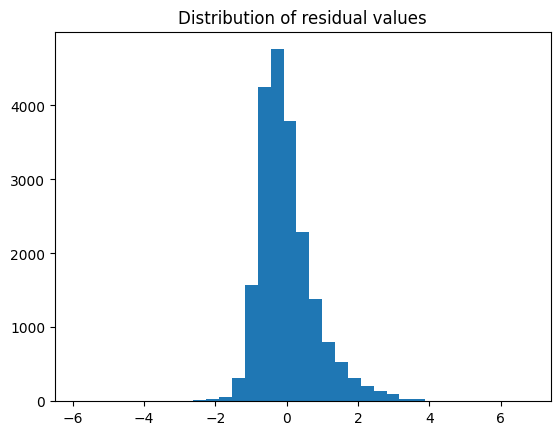

In [82]:
# Plotting the residuals of the model 3.1.2
plt.figure()
plt.hist(my_linreg5.resid, bins = 35)
plt.title('Distribution of residual values')
plt.show()

The distribution of residual values is close to a normal distribution although there is a longer right tail. Let's take a look at the Shaprio-Wilk test.

As a reminder:

$$ H_0 : \text{Data is normally distributed}  \quad vs. \quad H_1 : \text{Data is not normally distributed} $$

In [83]:
# calculating the shapiro test statisic and its p-value

print("Shapiro-Wilk Test: ", stats.shapiro(my_linreg5.resid))


Shapiro-Wilk Test:  ShapiroResult(statistic=0.9267939925193787, pvalue=0.0)


c:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The null hypothesis for the Shapiro-Wilk test is that the data are normally distributed. 
Because the p-value is less than 0.05, then the null hypothesis that the data are normally distributed is rejected.

The Shapiro-Wilk test is very sensitive! Let's try a normal Q-Q plot.

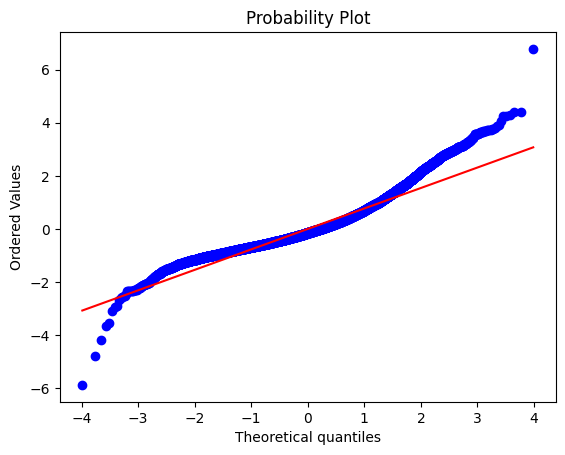

In [84]:
# Normal Q-Q plot

plt.figure()
stats.probplot(my_linreg5.resid, dist="norm", plot=plt)
plt.show()

The dots on the left show some outliers (smaller values than what we would expect from a normal distribution) while the overall curved U-shape and the dots on the right above the diagonal signal the right-skew we already saw in the histogram.

### 4.2 Homoscedasticity

The variance of residual is the same .

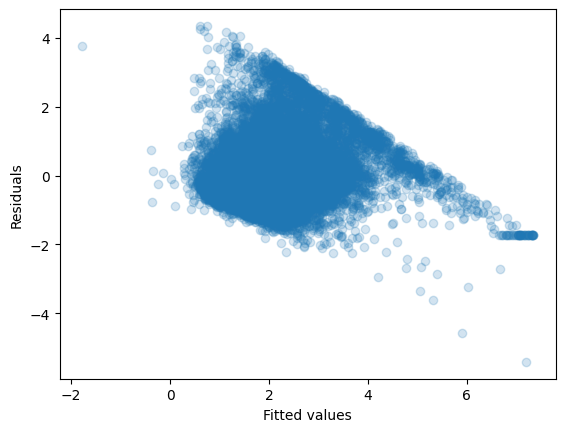

In [85]:
# Plot the residuals and the predicted values
plt.figure()
plt.scatter(my_linreg5.fittedvalues, my_linreg4.resid, alpha=0.2)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Although for the most part the residuals look random, there is a slight funnel shaped pattern here (which shows that the variance is getting smaller as the fitted values increase). So we can conclude that the residuals do not satisfy all our assumptions. Therefore, this model is not fully reliable, meaning that the p-values and coefficients cannot be trusted. 

As next steps, we can try to improve the model by using a different set of features or transforming the current predictors.

## 5. Conclusion

The approach we have shown above for variable selection is stepwise selection, where variables are added to and subtracted from the model one at a time and then the models are compared with specific performance criterion/s (in this case, we have used $R^2$). This is much more efficient than checking all possible subsets of predictors.

We would describe what we have done in Model 3.1.1, 3.1.2 and 3.1.3, as **backward selection**, fitting a full model and slowly remove terms one at a time, starting with the term with the least statistical signficance. An alternative to backward selection is **forward selection**, which can be seen in Model 3.2.1 and 3.2.2. Instead of starting with a full model, we start with a model containing only the intercept and a variable the most correlated with the dependent variable.

There are many other ways to select variable for your model. It is a complex process, and it can vary depending on the analysis goals, chosen performance criterions, external factors (existing research findings), etc..